<a href="https://colab.research.google.com/github/Yashmaini30/Tomato_Leaf-_Disease_Detection/blob/main/Copy_of_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tomatoleaf:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F619181%2F1105687%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240916%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240916T052603Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D2019a9f76932c178433303f540986b35f4539f87c51d04d01f0473fce6cc72ab396380bc7312c6d9a51ba80c98d4b547d2b4d357d7a90ef3f0a8770a1ff090d651f073b4d46ae5cdc748daf67621b6197d993b68266bc5aedcab168ea245795820dc620856966a2506c958f46ddf6607ae90bbec2ef491d4e17af6f88cf8f05ba570ebb2fea9dfbfbc4f7a0b70fc543dee88cac35c11b0158d9631b30ee6999953f521c38d20ebce65071c0c99671fc20e25999cb95d0d24341241532517fb885ef9c34771ba33d290c94e09b93629e2d83447ca8002fb56c9e55f951759bed777777586d5c2c2181fd6198ba70133d73047846b9758a5f89ac67b06a4e39197'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 187559775 bytes downloaded
Downloaded and uncompressed: tomatoleaf
Data source import complete.


In [2]:
import os
import numpy as np
import pandas as pd
from collections import Counter
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l1, l2           # L1 and L2 regularization for model regularization
from tensorflow.keras.preprocessing.image import ImageDataGenerator  # Data augmentation and preprocessing for images
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, BatchNormalization
# Various types of layers for building neural networks
from tensorflow.keras.applications import DenseNet121, EfficientNetB4, Xception  # Pre-trained models for transfer learning
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score


In [3]:
train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/train',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

train_data = train_data.map(lambda x, y: (x / 255.0, y))

Found 10000 files belonging to 10 classes.


In [4]:
val_data = tf.keras.preprocessing.image_dataset_from_directory(
    '/kaggle/input/tomatoleaf/tomato/val',
    labels='inferred',
    label_mode='categorical',
    image_size=(256, 256),
    batch_size=32)

val_data = val_data.map(lambda x, y: (x / 255.0, y))

Found 1000 files belonging to 10 classes.


In [ ]:

def count_images_in_directory(base_path):
    # Get a list of subdirectories (each subdirectory represents a label)
    labels = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]

    # Create a dictionary to store label counts
    label_counts = {}

    # Loop over each label and count the number of images in each directory
    for label in labels:
        label_path = os.path.join(base_path, label)
        image_files = [f for f in os.listdir(label_path) if os.path.isfile(os.path.join(label_path, f))]
        label_counts[label] = len(image_files)

    return label_counts

# Paths to the training and validation directories
train_path = '/kaggle/input/tomatoleaf/tomato/train'
val_path = '/kaggle/input/tomatoleaf/tomato/val'

# Get image counts for both directories
train_counts = count_images_in_directory(train_path)
val_counts = count_images_in_directory(val_path)

# Display the counts for each label in both train and val datasets
for label in train_counts:
    train_count = train_counts.get(label, 0)
    val_count = val_counts.get(label, 0)
    print(f"Label: {label}, Train Count: {train_count}, Val Count: {val_count}")


In [9]:
# Best hyperparameters from Bayesian Optimization
best_hyperparameters = {
    'units_dense1': 448,
    'dropout': 0.2,
    'units_dense2': 160,
    'learning_rate': 0.0007914514851509393
}

# Load the Xception model
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='avg'
)

# Print the summary of the Xception model
print("Xception Model Summary:")
xception_base.summary()

# Freeze the Xception base
xception_base.trainable = False

# Build the model with the best hyperparameters
model_best_model = Sequential()
model_best_model.add(xception_base)  # Adds Xception as the base
model_best_model.add(BatchNormalization())
model_best_model.add(Dense(best_hyperparameters['units_dense1'], activation='relu'))
model_best_model.add(Dropout(best_hyperparameters['dropout']))
model_best_model.add(BatchNormalization())
model_best_model.add(Dense(best_hyperparameters['units_dense2'], activation='relu'))
model_best_model.add(Dense(10, activation='softmax'))

# Compile the model
model_best_model.compile(
    optimizer=Adam(learning_rate=best_hyperparameters['learning_rate']),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print the summary of the combined model
print("\nCombined Model Summary:")
try:
    model_best_model.summary()
except Exception as e:
    print(f"Error in model summary: {e}")

# Train the model
history_best_model = model_best_model.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Unfreeze the top layers of the base model for fine-tuning
for layer in xception_base.layers[-20:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_best_model.compile(
    optimizer=Adam(learning_rate=best_hyperparameters['learning_rate'] / 10),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fine-tune the model
history_fine_tune = model_best_model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[EarlyStopping(patience=10, restore_best_weights=True)]
)

# Evaluate the fine-tuned model
y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = model_best_model.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Get validation accuracy and loss for the fine-tuning phase
val_accuracy_fine_tune = history_fine_tune.history['val_accuracy']
val_loss_fine_tune = history_fine_tune.history['val_loss']

# Calculate metrics
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Confusion Matrix:\n", conf_matrix)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print(f'Validation Accuracy (Last Epoch): {val_accuracy_fine_tune[-1]}')
print(f'Validation Loss (Last Epoch): {val_loss_fine_tune[-1]}')

Xception Model Summary:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 256, 256, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 127, 127, 32)   │            864 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 127, 127, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 127, 127, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 125, 125, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 125, 125, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 125, 125, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 125, 125, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 125, 125, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 125, 125, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 125, 125, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_16 (Conv2D)        │ (None, 63, 63, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 63, 63, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 20,806,952 (79.37 MB)

 Non-trainable params: 54,528 (213.00 KB)


Combined Model Summary:
Error in model summary: Undefined shapes are not supported.
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 87s 212ms/step - accuracy: 0.6361 - loss: 1.0897 - val_accuracy: 0.8110 - val_loss: 0.5985
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 162ms/step - accuracy: 0.8536 - loss: 0.4148 - val_accuracy: 0.8510 - val_loss: 0.4898
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 53s 169ms/step - accuracy: 0.9026 - loss: 0.2839 - val_accuracy: 0.8550 - val_loss: 0.4588
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 82s 169ms/step - accuracy: 0.9215 - loss: 0.2277 - val_accuracy: 0.8620 - val_loss: 0.4624
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.9259 - loss: 0.1925 - val_accuracy: 0.8730 - val_loss: 0.4346
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 55s 174ms/step - accuracy: 0.9478 - loss: 0.1470 - val_accuracy: 0.8530 - val_loss: 0.4930
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 52s 167ms/step - accuracy: 0.9475 - loss: 0.1459 - val_accuracy: 0.8730 - val_loss: 0.488

In [10]:
# Define and compile the model
model_cnn = Sequential()
model_cnn.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(64, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Conv2D(128, (3, 3), activation='relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))
model_cnn.add(Flatten())
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(10, activation='softmax'))

model_cnn.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Fit the model
history_cnn = model_cnn.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=10)]
)

val_accuracy_cnn = history_cnn.history['val_accuracy']
val_loss_cnn = history_cnn.history['val_loss']

y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = model_cnn.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')


Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 37s 91ms/step - accuracy: 0.3286 - loss: 1.9067 - val_accuracy: 0.7700 - val_loss: 0.6964
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.7112 - loss: 0.8385 - val_accuracy: 0.8000 - val_loss: 0.5910
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.7780 - loss: 0.6395 - val_accuracy: 0.8270 - val_loss: 0.5433
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - accuracy: 0.8263 - loss: 0.4972 - val_accuracy: 0.8530 - val_loss: 0.4368
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 61ms/step - accuracy: 0.8469 - loss: 0.4505 - val_accuracy: 0.8290 - val_loss: 0.5072
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 62ms/step - accuracy: 0.8770 - loss: 0.3621 - val_accuracy: 0.8630 - val_loss: 0.4505
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 20s 60ms/step - accuracy: 0.9006 - loss: 0.2934 - val_accuracy: 0.8550 - val_loss: 0.4850
Epoch 8/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9001 - loss: 0.2737 - val_accurac

In [11]:
print("\nCombined Model Summary:")
model_best_model.summary()


Combined Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 2048)                │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_28               │ (None, 2048)                │           8,192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 448)                 │         917,952 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 448)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_29               │ (None, 448)                 │           1,792 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 160)                 │          71,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 10)                  │           1,610 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 38,508,408 (146.90 MB)

 Trainable params: 8,322,770 (31.75 MB)

 Non-trainable params: 13,540,096 (51.65 MB)

 Optimizer params: 16,645,542 (63.50 MB)

In [12]:
# Define the DenseNet model
densenet_base = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='avg'
)

# Freeze the DenseNet base
densenet_base.trainable = False

# Build the model
model_denseNet = Sequential()
model_denseNet.add(densenet_base)
model_denseNet.add(BatchNormalization())
model_denseNet.add(Dense(256, activation='relu'))
model_denseNet.add(Dropout(0.35))
model_denseNet.add(BatchNormalization())
model_denseNet.add(Dense(120, activation='relu'))
model_denseNet.add(Dense(10, activation='softmax'))

# Compile the model
model_denseNet.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_densenet = model_denseNet.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=10)]
)

# Extract validation accuracy and loss
val_accuracy_densenet = history_densenet.history['val_accuracy']
val_loss_densenet = history_densenet.history['val_loss']


y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = model_denseNet.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 90s 199ms/step - accuracy: 0.3353 - loss: 2.0070 - val_accuracy: 0.7480 - val_loss: 0.9585
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 38s 104ms/step - accuracy: 0.7486 - loss: 0.8112 - val_accuracy: 0.8320 - val_loss: 0.5511
Epoch 3/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.8214 - loss: 0.5623 - val_accuracy: 0.8580 - val_loss: 0.4238
Epoch 4/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.8701 - loss: 0.4265 - val_accuracy: 0.8700 - val_loss: 0.3625
Epoch 5/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.8922 - loss: 0.3514 - val_accuracy: 0.8850 - val_loss: 0.3205
Epoch 6/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 102ms/step - accuracy: 0.9053 - loss: 0.2997 - val_accuracy: 0.8920 - val_loss: 0.2870
Epoch 7/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 43s 110ms/step - accuracy: 0.9191 - loss: 0.2509 - val_accuracy: 0.9000 - val_loss: 0.2607
Epoch 8/50
313/313 ━━━━━━━━━━━━━

In [ ]:
# Define the Xception model
xception_base = Xception(
    weights='imagenet',
    include_top=False,
    input_shape=(256, 256, 3),
    pooling='avg'
)

# Freeze the Xception base
xception_base.trainable = False

# Build the model
model_xception = Sequential()
model_xception.add(xception_base)
model_xception.add(BatchNormalization())
model_xception.add(Dense(256, activation='relu'))
model_xception.add(Dropout(0.35))
model_xception.add(BatchNormalization())
model_xception.add(Dense(120, activation='relu'))
model_xception.add(Dense(10, activation='softmax'))

# Compile the model
model_xception.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history_xception = model_xception.fit(
    train_data,
    epochs=50,
    validation_data=val_data,
    callbacks=[EarlyStopping(patience=10)]
)

# Extract validation accuracy and loss
val_accuracy_xception = history_xception.history['val_accuracy']
val_loss_xception = history_xception.history['val_loss']

y_true = np.concatenate([y for x, y in val_data], axis=0)
y_pred = model_xception.predict(val_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_true, axis=1)

# Compute metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
recall = recall_score(y_true_classes, y_pred_classes, average='macro')
precision = precision_score(y_true_classes, y_pred_classes, average='macro')
f1 = f1_score(y_true_classes, y_pred_classes, average='macro')

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Recall: {recall:.4f}')
print(f'Precision: {precision:.4f}')
print(f'F1 Score: {f1:.4f}')

Epoch 1/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 71s 196ms/step - accuracy: 0.3602 - loss: 1.8552 - val_accuracy: 0.7140 - val_loss: 1.0613
Epoch 2/50
313/313 ━━━━━━━━━━━━━━━━━━━━ 67s 160ms/step - accuracy: 0.7068 - loss: 0.8978 - val_accuracy: 0.7770 - val_loss: 0.6810


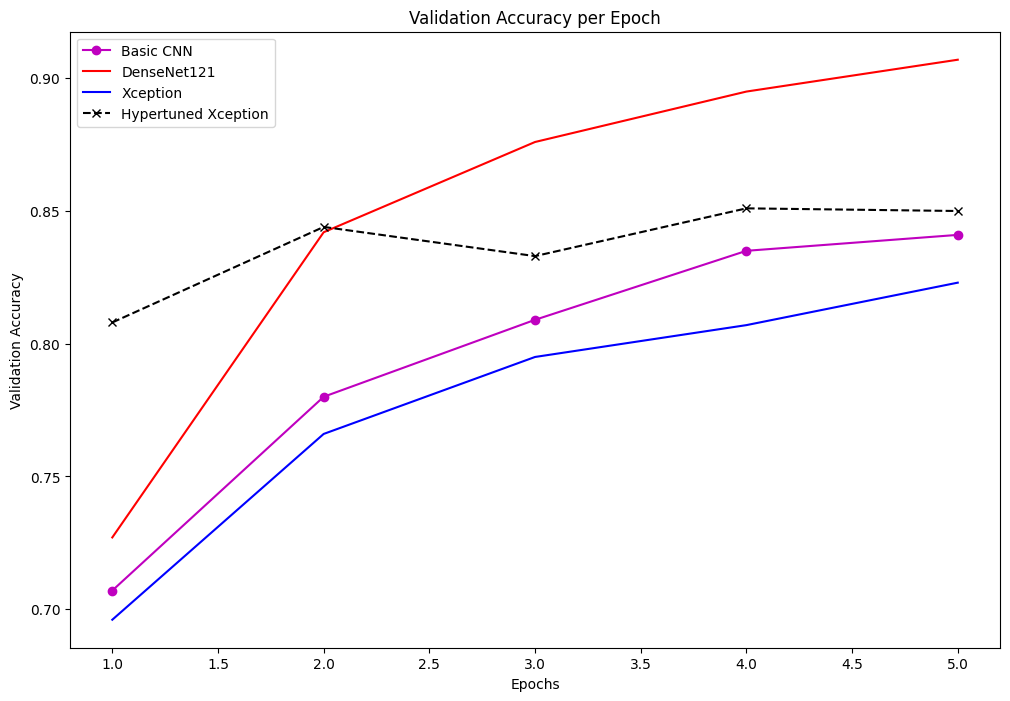

In [ ]:

import matplotlib.pyplot as plt

epochs = range(1, len(val_accuracy_fine_tune) + 1)

# Create the plot
plt.figure(figsize=(12, 8))

plt.plot(epochs, val_accuracy_cnn, 'm-o', label='Basic CNN')
plt.plot(epochs, val_accuracy_densenet, 'r-o', label='DenseNet121')
plt.plot(epochs, val_accuracy_xception, 'b-o', label='Xception')
plt.plot(epochs, val_accuracy_fine_tune, 'k--x', label='Hypertuned Xception')

# Add titles and labels
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Accuracy')
plt.legend()

# Save and show the plot
plt.savefig('model_comparison.png')
plt.show()


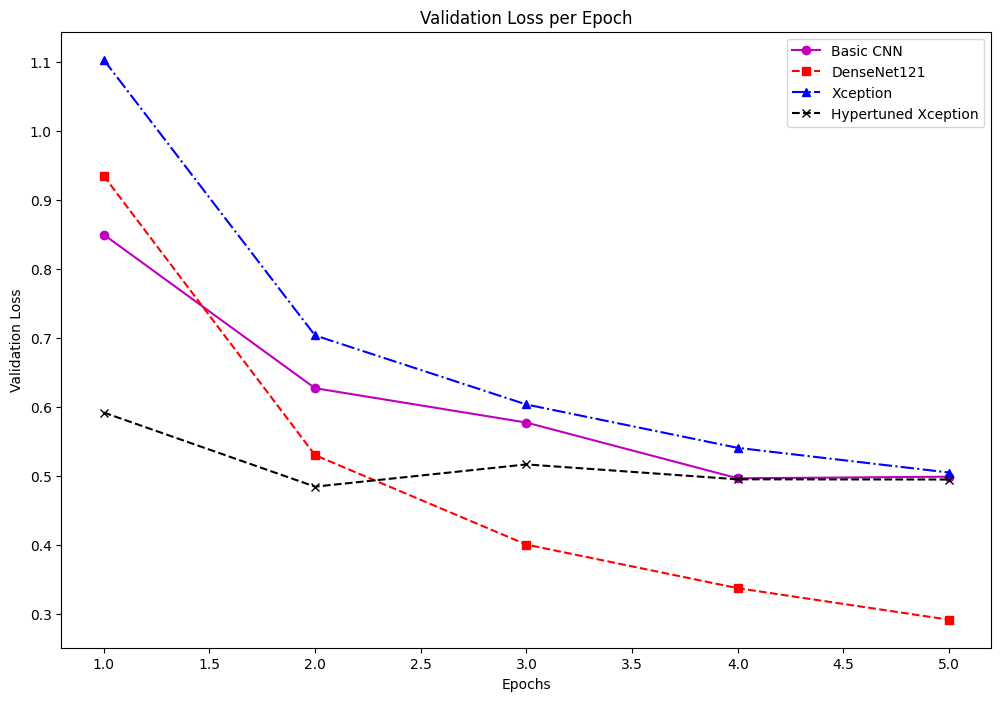

In [ ]:
import matplotlib.pyplot as plt

epochs = range(1, len(val_loss_fine_tune) + 1)

# Create the plot
plt.figure(figsize=(12, 8))

# Plot validation loss for each model
plt.plot(epochs, val_loss_cnn, 'm-o', label='Basic CNN')
plt.plot(epochs, val_loss_densenet, 'r-o', label='DenseNet121')
plt.plot(epochs, val_loss_xception, 'b-o', label='Xception')
plt.plot(epochs, val_loss_fine_tune , 'k--x', label='Hypertuned Xception')

# Add titles and labels
plt.title('Validation Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()

# Save and show the plot
plt.savefig('model_comparison_loss.png')
plt.show()
